# Production model and conclusions
In this notebook, we will pick up our best model from the model tuning notebook and look at its coefficients. Also, we will interpret how this model performs in the case of imbalance data, and how we might want to modify it for data imbalance. <br>
At the end, we will be diving into project conclusions and future recommendations.

In [44]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 

import re 
from nltk.sentiment.vader import SentimentIntensityAnalyzer # for sentiment analyzer

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

## Data preparation and train/test split
This part is similar to the previous notebooks. 

In [45]:
# read the data from preprocessed data that are saved into files
df = pd.read_csv('./../dataset/offmychestrelationship_advice_processed.csv')

X = df[['text', 'word_count', 'sentiment']]
y = df['subreddit']

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    random_state=42,
                                                    test_size=0.2,
                                                    stratify=y)
X_train = pd.DataFrame(X_train, columns=['text', 'word_count', 'sentiment'])
X_test = pd.DataFrame(X_test, columns=['text', 'word_count', 'sentiment'])

## Production model

This is the best performing model from the tuning stage

In [46]:
# create X train and test best on only the text column
Z_train = X_train['text']
Z_test = X_test['text']

# use the best model from tuning notebook and refit
pipe_cvec_logr_best = Pipeline([
    ('cvec', CountVectorizer(max_df=1.0,
                             max_features=3000,
                             min_df=4,
                             ngram_range=(1,2),
                             stop_words='english')),
    ('logr', LogisticRegression(C=0.07,
                                penalty='l2'))
])
pipe_cvec_logr_best.fit(Z_train, y_train)


c:\Users\masou\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('cvec',
                 CountVectorizer(max_features=3000, min_df=4,
                                 ngram_range=(1, 2), stop_words='english')),
                ('logr', LogisticRegression(C=0.07))])

In [47]:
print(f'train score: {pipe_cvec_logr_best.score(Z_train, y_train)}')
print(f'test score: {pipe_cvec_logr_best.score(Z_test, y_test)}')

train score: 0.9497232472324724
test score: 0.8865662465416538


In [48]:
y_test.value_counts(normalize=True)

1    0.56225
0    0.43775
Name: subreddit, dtype: float64

As we can see, the data seems quite balance. Let us extract some precision, recall, and f1 scores as well. 

In [49]:
pred = pipe_cvec_logr_best.predict(Z_test)
prec, recall, f1score, _ = classification_report(y_test, pred, output_dict=True)['1'].values()
print(f'precision: {round(prec,2)}' 
      f'\nrecall: {round(recall, 2)}'
      f'\nf1-score:{round(f1score, 2)}')

precision: 0.9
recall: 0.9
f1-score:0.9


## A closer look at misclassified cases
In this part, we will see if we can find any trends for when the model is able to classify listings vs when it cannot.

In [50]:
# get the countvectorizer transformer from the pipeline
cvec_step = pipe_cvec_logr_best.named_steps['cvec']
# get the output of count vectorizer and convert it into a dataframe
output_eval_df = pd.DataFrame(cvec_step.transform(Z_test).todense(), columns=cvec_step.get_feature_names_out())


In [51]:
output_eval_df['num_words'] = output_eval_df.sum(axis=1)
output_eval_df['label_actual'] = y_test.values
output_eval_df['label_pred'] = pred
output_eval_df['correct_pred'] = (pred == y_test.values).astype('int')
output_eval_df.head(5)

,10,10 years,100,11,12,13,14,15,15 years,16,...,yesterday,young,younger,youngest,youtube,zero,num_words,label_actual,label_pred,correct_pred
0,0,0,0,0,0,0,0,0,0,1,...,0,0,1,0,0,0,400,0,0,1
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,160,1,1,1
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,297,1,1,1
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,179,1,1,1
4,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,293,1,1,1


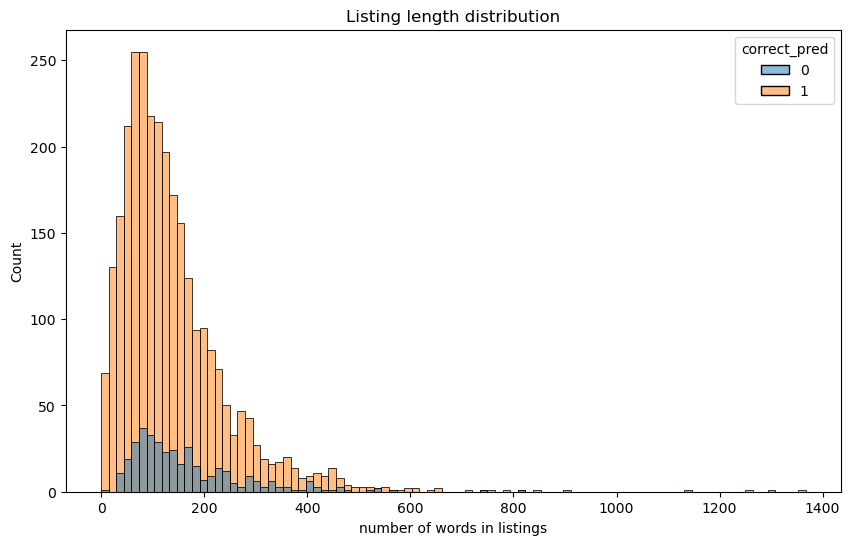

In [56]:
plt.figure(figsize=(10, 6))
sns.histplot(data=output_eval_df, x='num_words', hue='correct_pred')
plt.title('Listing length distribution')
plt.xlabel('number of words in listings');

In the graph above, we are plotting the distribution of the number of the words in each listing for the correctly and incorrectly classified listings. As we can see, the is no relation between the number of words in the listing and whether Logistic Regression classifier can correctly classify a listing. 

We also did some detailed analysis of classified and misclassified cases and the words in them but there were common words in both of them that did not reveal that much of information to us. 

## Inferential analysis on LogReg
Since we have been using logistic regression, we should be able to interpret the model and coefficients. In logistic regression, each coefficient shows the change in log odds of the event happening when the value of the feature changes by one unit. In the context of this project, the features are the number of times the popular words have appeared in our training data. 

First, let us look at the 10 words with the lowest coefficients in the logistic regression. The negative coefficient means as the number of these coefficients increases, the odds of the posts being classified as 0 (r/offmychest) increases. Since these coefficients have the biggest absolute values, a unit increase in the number of these words in a post impacts the log(odd) of our classification by the value of the coefficient (in favor of r/offmychest or the 0 class). For example, if the number of 'guy friends' increase in a post by one unit, the odds of that post being classified as a positive class (r/relationship_advice) decreases exp(-0.86) times, or becomes half. 

In [11]:
coeffs_df = pd.DataFrame(list(zip(pipe_cvec_logr_best.named_steps['cvec'].vocabulary_.keys(),
                                  pipe_cvec_logr_best.named_steps['logr'].coef_[0][:])), columns=['feature', 'coefficient'])
coeffs_df.sort_values(by='coefficient', ascending=True).head(30)

,feature,coefficient
2816,guy friends,-0.864334
442,entire,-0.759745
2932,time job,-0.451939
1731,sending,-0.451759
1416,arrived,-0.450660
1235,using,-0.444252
2080,unhealthy,-0.423991
10,know,-0.404741
1431,started crying,-0.403140
1564,blow,-0.400930


Now, let us do similar analysis for words with the highest (and positive) coefficients in our logistic regression model. 

In [10]:
coeffs_df.sort_values(by='coefficient', ascending=True).tail(30)

,feature,coefficient
13,speaking,0.828800
54,remember,0.833967
921,offended,0.844299
72,breaks,0.847692
16,away,0.860259
66,wait,0.862766
67,couch,0.864325
925,touch,0.869269
27,don,0.871016
59,care,0.877309


Looking at the list above, we can say that presence (or increase in the number of times these words are used) of the words like 'trust', 'god', 'apologized', 'favorite' has the highest impact on increasing the log(odd) of a listing being classified as 1 (r/relationship_advice).

## Production model with imbalance data
So far, we have been using balanced data. Now, let us assume the data is imbalance (minority class is '1' that is somehow important for us as well-e.g. for this project, class 1 is r/relationship_advice data and let us say we did not have that much of info from the relationship_advice subreddit but being able to classify this subreddit was very important for us)

In [12]:
temp = df[df['subreddit'] == 1]
temp = temp.sample(frac=0.06)
df_imbalance = pd.concat([df[df['subreddit'] == 0], temp], axis=0)

In [13]:
df_imbalance['subreddit'].value_counts(normalize=True)

0    0.928534
1    0.071466
Name: subreddit, dtype: float64

As we can see, the df_imbalance dataframe is severely imbalanced now and the 1 category (which we are 'assuming' is important for us) is underrepresented.

In [14]:
Ximb = df_imbalance.drop(columns='subreddit')
yimb = df_imbalance['subreddit']
Ximb_train, Ximb_test, yimb_train, yimb_test = train_test_split(Ximb, yimb,
                                                                test_size=0.2,
                                                                random_state=42,
                                                                stratify=yimb)

In [15]:
yimb_test.mean(), yimb_train.mean() 

(0.07170795306388526, 0.07140528203456147)

In [16]:
# create Z train and test based on only the text column
Zimb_train = Ximb_train['text']
Zimb_test = Ximb_test['text']

# fit the previous model to this new data
pipe_cvec_logr_best.fit(Zimb_train, yimb_train)

Pipeline(steps=[('cvec',
                 CountVectorizer(max_features=3000, min_df=4,
                                 ngram_range=(1, 2), stop_words='english')),
                ('logr', LogisticRegression(C=0.07))])

In [17]:
# see the scores
print(f'train score: {pipe_cvec_logr_best.score(Zimb_train, yimb_train)}')
print(f'test score: {pipe_cvec_logr_best.score(Zimb_test, yimb_test)}')

train score: 0.9747310074991848
test score: 0.9282920469361148


As we can see, the score (accuracy) is actually very good. In fact, the accuracy of the model is even better than when we did not have imbalance data. This is because in the case of data imbalance, the model becomes impacted by the majority class and while it misclassifies a big portion of that minority class, it's overall performance (accuracy) becomes better because it is easier to just focus of the majority class and predict those. <br> 
Let us see how our model has been performing on our minority class.

In [20]:
predimb = pipe_cvec_logr_best.predict(Zimb_test)
prec_imb, recall_imb, f1score_imb, _ = classification_report(yimb_test, predimb, output_dict=True)['1'].values()
print(f'precision: {round(prec_imb,2)}' 
      f'\nrecall: {round(recall_imb, 2)}'
      f'\nf1-score:{round(f1score_imb, 2)}')

precision: 0.5
recall: 0.28
f1-score:0.36


As we can see, the original production model performs very poorly on the minority class when the data show strong imbalance because the majority will overtake the training process. Let us see if we can alleviate this issue. To do that, we will retrain the model by giving a higher weight to minority class (using `class_weight`). This might reduce our overall model score but should help us get better metrics on the minority class.  

In [19]:
# use the best model from tuning notebook and refit
pipe_cvec_logr_imb = Pipeline([
    ('cvec', CountVectorizer(max_df=1.0,
                             max_features=3000,
                             min_df=4,
                             ngram_range=(1,2),
                             stop_words='english')),
    ('logr', LogisticRegression(C=0.07,
                                penalty='l2',
                                class_weight={0:1, 1:30}))
])
pipe_cvec_logr_imb.fit(Zimb_train, yimb_train)

# see the scores
print(f'train score: {pipe_cvec_logr_imb.score(Zimb_train, yimb_train)}')
print(f'test score: {pipe_cvec_logr_imb.score(Zimb_test, yimb_test)}')
predimb = pipe_cvec_logr_imb.predict(Zimb_test)
prec_imb, recall_imb, f1score_imb, _ = classification_report(yimb_test, predimb, output_dict=True)['1'].values()
print(f'precision: {round(prec_imb,2)}' 
      f'\nrecall: {round(recall_imb, 2)}'
      f'\nf1-score:{round(f1score_imb, 2)}')

c:\Users\masou\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


train score: 0.9791327029670688
test score: 0.9061277705345502
precision: 0.4
recall: 0.6
f1-score:0.48


This table shows model performance for the original production model vs. that of weighted model for severely imbalanced data:

| metric | model without weighted classes | model with weighted classes|
| --------      | ------ | ------|
| test score    | 0.93   | 0.91  |
| precision     | 0.50  | 0.40  |
| recall        | 0.28   | 0.60  |
| f1-score      | 0.36   | 0.48  |

As we can see from these scores, giving more weight to the positive class (the minority class), our model is able to predict more positives (and a higher percentage of actual positives), this means the model sensitivity (recall) increases and at the same time, the number of false positives increases as well, which means a decreased precision. 


## Key takeaways

As we have seen, the production model does not have any issue predicting balanced data, however, when the data become imbalance, then same production data struggles to predict the positive class (the imbalance class). For this to be resolved, we had to modify the production model by giving more weight to the underrepresented class (here the positive class) so that the model can perform better on that class (and predict more positives).

## Project conclusions and recommendations
In this project, we used the reddit API's to scape more than 15,000 listings on different subreddits (r/offmychest and r/relationship_advice) and analyze their information. The primary goal of this work is to see whether we can use NLP to classify different listings in reddit based on the subreddit they belong to. To achieve this goal we have employed multiple estimators (KNN, Logistic Regression, Naive Bayes, and Random Forest) along with different transformers (CountVectorizer and TfidfVectorizer). Here are a few important findings:
- EDA has revealed that there are groups of popular words that are unique to each of these subreddits and could be used as indicators for our classification problems. 
- In addition to the text in each listing, we have discovered different pattern in the data (e.g. sentiment analysis and length of the listing) that could be used to gain more information for our classification problem. 
- Among all the estimators and transformers, we have found that CountVectorizer with Logistic regression generates us the best results. 
- A general trend that was observed in all of the classifiers was the fact that our models were all having a relatively high variance. Increasing the number of words we used for our classification usually improved the training score without that much of help with the test data (overfitting). 
- Since neither of the subreddits we were investigating was more important than the other one, we used the accuracy score (tn + tp)/total observations in most of our evaluations. 
- The original data were were using was quite balance but to see how the production model performs on imbalanced data, we created some severely imbalanced (while the positive class was of more importance for us). The base model was not particularly the best model for the imbalance data so what we did was to increase the weight of the underrepresented class in our model and use metrics like precision, recall, and f1-score instead so that we tune the model for the specific purpose of interest, and the class of interest. Using this approach, we were able to improve model's performance for underrepresented classes. <br>
These findings are important in a sense that these results could be used to classify subreddit listings with an accuracy of 88%. In addition to that, we have suggested some extra steps that help with imbalance data and how we can modify the modeling process to get the best metrics (depending on whether outcomes like false positive or false negative are important for us) based on the scope and purpose of the research. 

**Future recommendations**

Here are a few areas identified as where we could further work and improve upon:
- Automate data scraping by using timed scripts.
- Use features other than just the text of the listing. Information like location, time, etc might help us improve performance of our classifier. This might require collecting data consistently, over a longer period of time. 
- The current transformers do not consider the relation between the words and the context in which the words are used. Instead, using more advanced language models to capture the meaning and relation between the words and having more targeted data preparation could help us get better results. 
